In [1]:
import pandas as pd
import numpy as np
import sklearn as sl

In [2]:
ds = pd.read_csv('./data/train.csv', index_col='id')
ds.head(3)

,word,stress,num_syllables,lemma
id,,,,
0,румяной,2,3,румяный
1,цифрами,1,3,цифра
2,слугами,1,3,слуга


In [3]:
ds_ss = pd.read_csv('./data/sample_submission.csv')
ds_ss.head(3)

,id,stress
0,0,1
1,1,1
2,2,1


In [4]:
ds_ss.loc[ds_ss['stress'] != 1]

,id,stress


In [5]:
ds_test = pd.read_csv('./data/test.csv')
ds_test.head(3)

,id,word,num_syllables,lemma
0,0,эпилепсия,5,эпилепсия
1,1,относящейся,5,относиться
2,2,размышлениями,6,размышление


In [6]:
ds.describe()

,stress,num_syllables
count,63438.000000,63438.000000
mean,2.209354,3.489691
std,0.912874,1.158803
min,1.000000,1.000000
25%,2.000000,3.000000
50%,2.000000,3.000000
75%,3.000000,4.000000
max,6.000000,6.000000


# Поиск шумов

## Проверка на дурака: ударение на согласную букву не ставится!

In [7]:
ds_copy = ds.copy()

In [8]:
# «а» «у» «о» «и» «э» «ы» «я» «ю» «е» «ё»
vowels = ['а', 'е', 'ё', 'у', 'о', 'и', 'э', 'ы', 'ю', 'я']

#  Токенизация слов

In [9]:
ds[1000:1030]

,word,stress,num_syllables,lemma
id,,,,
1000,тренировками,3,5,тренировка
1001,профиле,1,3,профиль
1002,звала,2,2,звать
1003,окружающими,3,6,окружающий
1004,трансплантации,3,5,трансплантация
1005,смотрелся,2,3,смотреться
1006,радиочасы,5,5,радиочасы
1007,съемки,1,2,съемка
1008,платки,2,2,платок


* можно на выход подавать номер слога
* можно на выход подавать номер ударной буквы, тогда НС будет как бы бинарно классифицировать падает ли на эту букву ударение

# Посчитаем длину слов

In [10]:
ds['words_lenght'] = [len(word) for word in ds['word']]
ds.sample(5)

,word,stress,num_syllables,lemma,words_lenght
id,,,,,
29276,сати,1,2,сати,4
19786,облачный,1,3,облачный,8
53628,бюстгальтер,2,3,бюстгальтер,11
20650,соску,2,2,сосок,5
48766,находили,3,4,находить,8


In [11]:
max_words_lenght = np.max(ds['words_lenght'])
max_words_lenght

20

In [12]:
ds['lemmas_lenght'] = [len(word) for word in ds['lemma']]
ds.sample(5)

,word,stress,num_syllables,lemma,words_lenght,lemmas_lenght
id,,,,,,
456,выражена,1,4,выражать,8,8
45738,оружейной,3,4,оружейный,9,9
53558,бросьте,1,2,бросать,7,7
6946,имения,2,4,имение,6,6
4888,неподходящий,4,5,неподходящий,12,12


In [13]:
max_lemms_lenght = np.max(ds['lemmas_lenght'])
max_lemms_lenght

20

In [14]:
min_lemms_lenght = np.min(ds['lemmas_lenght'])
min_lemms_lenght

2

In [15]:
ds.loc[ds['lemmas_lenght'] <= 2]

,word,stress,num_syllables,lemma,words_lenght,lemmas_lenght
id,,,,,,
2994,уму,2,2,ум,3,2
4199,яру,1,2,яр,3,2
4738,ля,1,1,ля,2,2
6076,фе,1,1,фе,2,2
6191,ин,1,1,ин,2,2
...,...,...,...,...,...,...
59275,ша,1,1,ша,2,2
60673,мю,1,1,мю,2,2
61309,югу,1,2,юг,3,2


In [16]:
two_letter_words = ['еж', 'мы', 'уж', 'ус', 'яз', 'юг']

In [17]:
very_short_words = ds.loc[(ds['lemmas_lenght'] <= 2) & (~ds['lemma'].isin(two_letter_words))]

In [18]:
ds = ds.drop(index=very_short_words.index, axis=1)

In [19]:
bad_indexes = ds.loc[(ds['num_syllables'] == 1) & (~ds['lemma'].isin(two_letter_words))].index
ds = ds.drop(index=bad_indexes, axis=1)
len(bad_indexes)

1318

In [20]:
pd.set_option('display.max_rows', None)
three_letters_words = ds.loc[(ds['lemmas_lenght'] == 3) & (ds['words_lenght'] == 3)]
three_letters_words

,word,stress,num_syllables,lemma,words_lenght,lemmas_lenght
id,,,,,,
591,тыя,1,2,тыя,3,3
966,гаи,1,2,гаи,3,3
1047,эва,1,2,эва,3,3
1239,эла,1,2,эла,3,3
2054,ное,1,2,ной,3,3
2216,зою,1,2,зоя,3,3
2724,чао,1,2,чао,3,3
2875,тою,1,2,тот,3,3
3091,эры,1,2,эра,3,3


In [21]:
ds = ds.drop(index=three_letters_words.index, axis=1)

In [22]:
pd.set_option('display.max_rows', 5)

In [23]:
ds.loc[ds['num_syllables'] == 2]

,word,stress,num_syllables,lemma,words_lenght,lemmas_lenght
id,,,,,,
6,чёрта,1,2,черт,5,4
34,хроник,1,2,хроника,6,7
...,...,...,...,...,...,...
63428,рома,1,2,рома,4,4
63431,кулик,2,2,кулик,5,5


In [24]:
ds.sample(5)

,word,stress,num_syllables,lemma,words_lenght,lemmas_lenght
id,,,,,,
22163,поможешь,2,3,помогать,8,8
25981,домовой,3,3,домовой,7,7
19630,промышленную,3,5,промышленный,12,12
52566,перебирал,4,4,перебирать,9,10
49983,справедливых,3,4,справедливый,12,12


# Токенизируем слово и лемму

In [25]:
letter_list = ['а', 'б', 'в', 'г', 'д', 'е', 'ё', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я']
letter_by_number = {}
i = 1
for letter in letter_list:
    letter_by_number[letter] = i
    i+=1
letter_by_number

{'а': 1,
 'б': 2,
 'в': 3,
 'г': 4,
 'д': 5,
 'е': 6,
 'ё': 7,
 'ж': 8,
 'з': 9,
 'и': 10,
 'й': 11,
 'к': 12,
 'л': 13,
 'м': 14,
 'н': 15,
 'о': 16,
 'п': 17,
 'р': 18,
 'с': 19,
 'т': 20,
 'у': 21,
 'ф': 22,
 'х': 23,
 'ц': 24,
 'ч': 25,
 'ш': 26,
 'щ': 27,
 'ъ': 28,
 'ы': 29,
 'ь': 30,
 'э': 31,
 'ю': 32,
 'я': 33}

In [26]:
len(letter_by_number)

33

In [27]:
# Tokenize words
for i in range(0, max_words_lenght):
    ds[f'wl{i+1}'] = [(letter_by_number[word[i]] if len(word) > i else 0) for word in ds['word']]
    # is letter vowel?
    ds[f'is_wl_v{i+1}'] = [(1 if (len(word) > i and word[i] in vowels) else 0) for word in ds['word']]
    # # How many vowels in the word?
    # i = 0
    # num_lemmas_syllables = 0
    # for id_ in ds['id']:
    #     word = ds.loc[ds['id'] == id_]['word']
    #     for letter in word:
    #         if letter in vowels:
    #             num_lemmas_syllables += 1
    #     ds.loc[ds['id'] == id_, 'num_lemmas_syllables'] = num_lemmas_syllables

In [28]:
# Tokenize lemms
for i in range(0, max_lemms_lenght):
    ds[f'll{i+1}'] = [(letter_by_number[lemma[i]] if len(lemma) > i else 0) for lemma in ds['lemma']]
    # is letter vowel?
    ds[f'is_ll_v{i+1}'] = [(1 if (len(lemma) > i and lemma[i] in vowels) else 0) for lemma in ds['lemma']]

In [29]:
# pd.set_option('display.max_columns', None)
ds.sample(3)

,word,stress,num_syllables,lemma,words_lenght,lemmas_lenght,wl1,is_wl_v1,wl2,is_wl_v2,...,ll16,is_ll_v16,ll17,is_ll_v17,ll18,is_ll_v18,ll19,is_ll_v19,ll20,is_ll_v20
id,,,,,,,,,,,,,,,,,,,,,
2200,греческий,1,3,греческий,9,9,4,0,18,0,...,0,0,0,0,0,0,0,0,0,0
24632,пожилой,3,3,пожилой,7,7,17,0,16,1,...,0,0,0,0,0,0,0,0,0,0
49635,заговорила,4,5,заговаривать,10,12,9,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# pd.set_option('display.max_columns', None)
ds.drop(['word', 'lemma'], axis=1).corr()

,stress,num_syllables,words_lenght,lemmas_lenght,wl1,is_wl_v1,wl2,is_wl_v2,wl3,is_wl_v3,...,ll16,is_ll_v16,ll17,is_ll_v17,ll18,is_ll_v18,ll19,is_ll_v19,ll20,is_ll_v20
stress,1.000000,0.656427,0.577145,0.578832,0.028239,0.188028,-0.071823,-0.008621,-0.007377,-0.021467,...,0.104831,0.061694,0.064374,0.030821,0.042585,0.023436,0.024785,0.017506,0.015199,0.007829
num_syllables,0.656427,1.000000,0.830938,0.748123,0.011482,0.179003,-0.039289,-0.024349,-0.023500,-0.006114,...,0.126625,0.072050,0.084334,0.040366,0.055126,0.034416,0.029919,0.019869,0.017251,0.008885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ll20,0.015199,0.017251,0.035496,0.035402,0.004990,-0.003628,-0.000969,-0.000512,0.001297,0.002229,...,0.017887,0.202266,0.128427,-0.000175,0.236278,-0.000121,0.566811,0.496104,1.000000,0.832051
is_ll_v20,0.007829,0.008885,0.017338,0.018235,0.001892,-0.001869,0.003088,-0.004959,0.001653,0.006170,...,0.002188,0.104181,0.077201,-0.000090,0.170420,-0.000063,0.224431,-0.000036,0.832051,1.000000


In [31]:
ds.drop(['word', 'lemma', 'words_lenght', 'lemmas_lenght'], axis=1).corr()['stress'].to_list()

[1.0,
 0.6564274789160506,
 0.02823862360735054,
 0.18802779161252645,
 -0.0718227582371788,
 -0.008620662948675941,
 -0.00737699684962736,
 -0.0214673581565813,
 -0.07724964319959438,
 0.10547305912164015,
 -9.91412008924467e-05,
 -0.0343196645097861,
 0.043282686579965916,
 0.13481201214496105,
 0.174978879458847,
 0.14501645908899968,
 0.2754660289205564,
 0.19915758898420444,
 0.33889184029145636,
 0.24171128275613105,
 0.362823581438721,
 0.277696113942248,
 0.3452403547419484,
 0.27784890607242213,
 0.32128390174954763,
 0.25123256899779034,
 0.27256531938641043,
 0.2110920842655702,
 0.21514511143735407,
 0.16368839074586292,
 0.1522719739656988,
 0.11286465723070692,
 0.09723905086858724,
 0.060830151346871655,
 0.05629659976997764,
 0.022536872821928323,
 0.035636797674180584,
 0.021987998574443706,
 0.025282876121637588,
 0.017361941401902233,
 0.014853550213908008,
 nan,
 0.02800792693796384,
 0.18826560296886236,
 -0.07029622525129446,
 -0.008151622194794482,
 -0.0078538095

In [32]:
# ds_ = ds.drop(['id', 'word', 'lemma', 'words_lenght', 'lemmas_lenght'], axis=1)
ds_ = ds.drop(['word', 'lemma'], axis=1)

In [33]:
from sklearn.utils import shuffle
ds_ = shuffle(ds_)

# Trying AI

In [34]:
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, LeakyReLU, Conv1D, MaxPooling1D, Embedding, Flatten
import tensorflow as tf
from tensorflow.keras import Sequential
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [35]:
# X, y = df.values[:, :-1], df.values[:, -1]
X = ds_.drop(['stress', 'num_syllables', 'words_lenght', 'lemmas_lenght'], axis=1)
# y = ds_['stress']

In [36]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
y = pd.DataFrame(encoder.fit_transform(ds_[['stress']]). toarray ())

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle=True)

In [38]:
pd.set_option('display.max_columns', None)
X_train

,wl1,is_wl_v1,wl2,is_wl_v2,wl3,is_wl_v3,wl4,is_wl_v4,wl5,is_wl_v5,wl6,is_wl_v6,wl7,is_wl_v7,wl8,is_wl_v8,wl9,is_wl_v9,wl10,is_wl_v10,wl11,is_wl_v11,wl12,is_wl_v12,wl13,is_wl_v13,wl14,is_wl_v14,wl15,is_wl_v15,wl16,is_wl_v16,wl17,is_wl_v17,wl18,is_wl_v18,wl19,is_wl_v19,wl20,is_wl_v20,ll1,is_ll_v1,ll2,is_ll_v2,ll3,is_ll_v3,ll4,is_ll_v4,ll5,is_ll_v5,ll6,is_ll_v6,ll7,is_ll_v7,ll8,is_ll_v8,ll9,is_ll_v9,ll10,is_ll_v10,ll11,is_ll_v11,ll12,is_ll_v12,ll13,is_ll_v13,ll14,is_ll_v14,ll15,is_ll_v15,ll16,is_ll_v16,ll17,is_ll_v17,ll18,is_ll_v18,ll19,is_ll_v19,ll20,is_ll_v20
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40391,9,0,1,1,13,0,16,1,4,0,16,1,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,1,1,13,0,16,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
63041,12,0,1,1,18,0,10,1,15,0,21,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,1,1,18,0,10,1,15,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14928,17,0,18,0,16,1,3,0,16,1,8,0,1,1,13,0,10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,18,0,16,1,3,0,16,1,8,0,1,1,20,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14739,12,0,1,1,3,0,12,0,1,1,9,0,24,0,6,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,1,1,3,0,12,0,1,1,9,0,6,1,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
y_train

,0,1,2,3,4,5
25927,0.0,1.0,0.0,0.0,0.0,0.0
42848,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
60817,0.0,0.0,1.0,0.0,0.0,0.0
4023,0.0,1.0,0.0,0.0,0.0,0.0


In [40]:
n_futures = len(X.columns)
n_futures

80

In [41]:
# Create a model
model = Sequential()

# model.add(BatchNormalization())

# Add input layer
# model.add(Dense(83, activation='softmax', input_shape = (n_futures,) ))
# model.add(Dense(100, activation='relu', input_shape = (n_futures,) ))
model.add(Embedding(input_dim=33, output_dim=6))

model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))

model.add(Dropout(0.1))
# model.add(Dropout(0.25))

model.add(BatchNormalization())
# model.add(Conv1D(filters=20 , kernel_size=4, strides=1, padding='same', activation='relu'))
model.add(Conv1D(filters=20 , kernel_size=4, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(2))

# model.add(Dense(100, activation='relu', input_shape = (n_futures,) ))
# model.add(Dense(100, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(100, activation='relu'))

# model.add(Conv1D(filters=20 , kernel_size=4, strides=1, padding='same', activation='relu'))
# model.add(MaxPooling1D(2))
# model.add(Dense(100, activation='relu'))

model.add(Dropout(0.2))

model.add(BatchNormalization())

model.add(Flatten())

# output layer
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              # optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [42]:
# # Compile

# model.compile(loss='mse',              
#               # optimizer=Adam(learning_rate=0.2), 
#               # optimizer='adam',
#               optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
#               # metrics=['mae'])
#               metrics=['mse'])

print(model.summary()) # Выводим структуру сети
# Train NN
history=model.fit(X_train,
                  y_train,
                  batch_size=100,
                  epochs=50,
                  # Подавляем вывол протоколов обучения.
                  # verbose=0,
                  # Используем 20% обучающих данных для валидации.
                  # validation_split = 0.2)
                 )



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - accuracy: 0.5541 - loss: 1.0430
Epoch 2/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.6589 - loss: 0.7874
Epoch 3/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - accuracy: 0.6687 - loss: 0.7612
Epoch 4/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.6913 - loss: 0.7249
Epoch 5/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 38s 34ms/step - accuracy: 0.6880 - loss: 0.7242
Epoch 6/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - accuracy: 0.6999 - loss: 0.7075
Epoch 7/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.7024 - loss: 0.7011
Epoch 8/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.7097 - loss: 0.6910
Epoch 9/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.7072 - loss: 0.6945
Epoch 10/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.7112 - loss: 0.6852
Epoch 11/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.7206 - loss: 0.6697
Epoch 12/50
558/558 ━━━━━

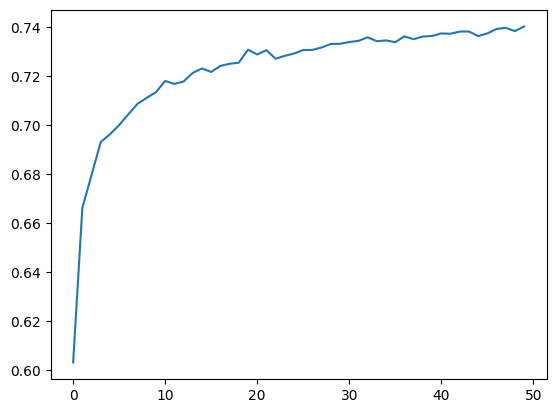

In [43]:
plt.plot(history.history['accuracy'])
# plt.plot(history.history['hindle'])
plt.show()

194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


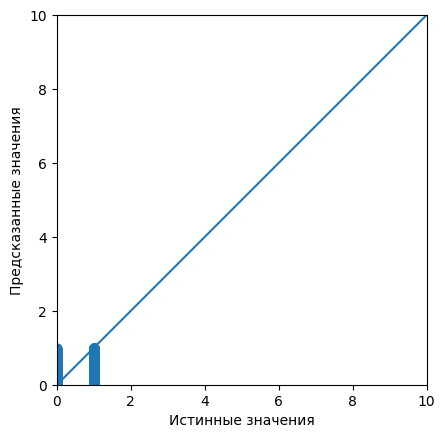

In [44]:
test_predictions = model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
lims = [0, 10]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.show()

In [45]:
from sklearn.metrics import roc_curve

In [46]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
# fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1], pos_label=1)
fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test)[:,1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


ValueError: multilabel-indicator format is not supported

<Figure size 1000x800 with 0 Axes>